### About This Notebook

This notebook aims to train a Deep Neural Network (DNN) to efficiently predict the Mechanism of Action (MoA) of a drug, given gene expression and cell viability data.  We introduce a novel approach for processing the data before feeding the data into a modified version of TabNet, Google's recent DNN architecture created to process tabular data.  

By the nature of the drug, there can be multiple MoA's, making this a multi-label classification problem.  



> #### About our model




In this notebook we will explore TabNet, a high-performance and interpretable DNN that is designed specifically for tabular data.  TabNet introduces sequential-attention, too, to benefit instances where certain features may be particularly important at the current decision step.  

Introduced by Google AI earlier this year, TabNet has been made open-source and pubicly available.  

For the original paper: https://arxiv.org/pdf/1908.07442.pdf



 > #### Visualize our Data






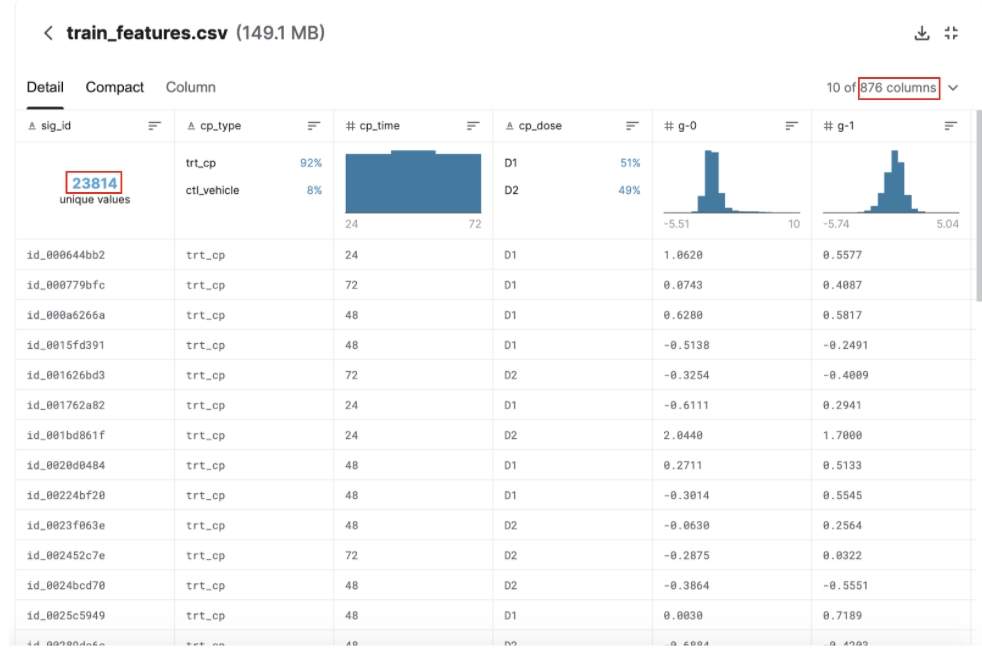

## Import Libraries and Data

In [1]:
###Install pytorch_tabnet
!pip uninstall -y typing # this should avoid  AttributeError: type object 'Callable' has no attribute '_abc_registry'

!pip install  "git+https://github.com/dreamquark-ai/tabnet.git@develop#egg=pytorch_tabnet" --upgrade
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier


  Cloning https://github.com/dreamquark-ai/tabnet.git (to revision develop) to /tmp/pip-install-axy8kc98/pytorch-tabnet
  Running command git clone -q https://github.com/dreamquark-ai/tabnet.git /tmp/pip-install-axy8kc98/pytorch-tabnet
ERROR: Operation cancelled by user


ModuleNotFoundError: ignored

In [2]:

import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.metrics import roc_auc_score, log_loss

import pandas as pd
import numpy as np
np.random.seed(0)

from tqdm.notebook import tqdm

import os

from matplotlib import pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data...

In [3]:
print(os.path.dirname(os.path.abspath('Bioinf590_TabNet.ipynb')))

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Bioinf 590/Final Project'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print('In Working Directory', os.listdir(GOOGLE_DRIVE_PATH))

DATA_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'lish-moa')

train = pd.read_csv(DATA_PATH+"/train_features.csv")
train_processed = pd.read_csv(DATA_PATH+"/train_processed_final.csv")

train_targets = pd.read_csv(DATA_PATH+'/train_targets_scored.csv')
train_targets.drop(columns=["sig_id"], inplace=True)
print(DATA_PATH)
test = pd.read_csv(DATA_PATH+'/test_features.csv')
train_drug = pd.read_csv(DATA_PATH+'/train_drug.csv')

/content
In Working Directory ['lish-moa', 'TabNet.pt', 'y_test_pred.pt', 'TabNet_zScore.pt', 'TabNet_no_zScore.pt', 'Early_Findings.gdoc', 'baseline_sklearn.ipynb', 'baseline-NN.ipynb', 'Bioinf590_TabNet.ipynb', 'baseline+1D CNN.ipynb', 'Bioinf_Final_Presentation.gslides']
drive/My Drive/Bioinf 590/Final Project/lish-moa


We will use Google's GPU, run the following code to check GPU is enabled

In [4]:
if torch.cuda.is_available:
  print('Yeah dude, im the GPU and ready to dance!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Yeah dude, im the GPU and ready to dance!


## Data Visualization

Gurpreet, this is PCA code, try it out.  But I think we should do something more comprehensive, like t-SNE or UMAP

In [ ]:
train_processed = pd.read_csv(DATA_PATH+"/train_processed_final.csv")
data = train_processed.drop(columns=['Unnamed: 0','sig_id', 'Set']).values

In [ ]:
xx = train_processed[train_drug['drug_id']=='cacb2b860']
xx = xx[xx['cp_time'] == 1]
xx#['g-1'].var()

,Unnamed: 0,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,Set
25,25,25,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,0.7785,0.7062,-0.7951,1.3770,0.2856,-0.8331,0.3879,1.3290,-0.4746,0.0857,-0.2745,-0.1093,0.2603,0.7386,-0.6665,-1.6520,-0.9262,0.0000,1.6310,-0.2933,0.2043,-2.2070,0.1383,-0.4966,0.6922,-0.4077,0.2303,-0.0456,-0.7447,...,-0.0178,0.3768,0.4318,-0.1051,0.3933,-0.3189,0.4128,-0.2116,-1.0410,0.7798,0.1579,1.7250,1.4490,0.9117,-0.0754,-0.8396,0.7640,1.2080,1.1890,0.2114,0.6335,0.3265,-0.1056,0.5478,0.7477,1.2340,0.5035,-0.6591,0.3023,0.6171,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,0
47,47,47,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,0.6459,-0.0109,1.0120,-0.0864,-0.3817,-1.0600,0.9435,0.6296,0.3864,0.1420,0.9834,0.4189,0.7980,-0.2132,0.7651,-1.2410,0.0747,-1.5750,0.1535,-0.0840,0.6705,-0.7517,-0.2756,-1.0920,-0.8683,0.3021,-0.3164,-0.2074,0.4587,...,-0.5262,-0.2982,-0.2491,-0.6373,-1.0040,-0.6726,-0.0321,-0.5398,-0.7518,0.0370,0.7213,-0.3466,0.2354,-0.4432,-0.1020,-0.9391,-1.1970,0.1365,-0.9264,0.5828,-0.7379,-0.4354,0.6077,-0.3771,-0.6525,-0.4169,-1.0640,-0.3331,-0.5761,-0.3085,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,0
117,117,117,0,1,1,-1.6700,-2.3240,-0.9795,0.3699,-1.9270,1.2500,1.2700,-1.4390,0.8917,-0.1233,1.0080,0.5013,0.2772,0.1357,0.7255,0.2580,0.1948,0.6774,-0.4597,-0.1899,1.0500,-2.6040,-0.2826,0.0003,1.1170,0.0727,-0.0575,-0.4787,1.2710,1.1190,0.2386,1.5000,-2.1360,0.2528,0.5496,...,0.8150,-0.2560,0.2953,-0.1903,1.2140,0.6044,0.6100,1.7690,1.2940,1.2970,-0.5230,1.6070,1.4460,0.3534,0.9867,-0.0846,0.4881,0.4594,0.5153,0.0393,0.0846,0.9874,1.4820,0.9535,1.0950,0.1159,1.6220,1.6190,0.3587,0.8804,0.7349,-0.2593,0.3976,1.4450,1.1400,0.1478,0.8284,0.2281,1.6320,0
148,148,148,0,1,0,-0.3176,0.8375,-0.3773,0.5555,-0.4877,0.3413,-0.8204,-1.1320,1.0220,2.8340,1.5950,-0.4357,2.4850,0.0169,0.3497,0.2446,0.9030,1.0480,-0.0236,0.1287,-0.2542,-0.9599,-1.2090,0.8248,1.2270,0.9403,1.2220,0.7952,0.0654,0.1419,0.4826,-0.3608,-1.2470,0.8987,-1.6590,...,0.3862,0.1679,-0.1606,0.7098,-0.2421,0.7089,-0.1834,0.3628,0.3475,-0.4740,0.3952,0.1573,1.7930,0.3352,0.7680,0.6317,0.3930,0.1769,0.6985,0.9422,1.4140,0.9016,0.0636,0.8527,0.9618,0.8359,0.8941,0.3700,0.1103,0.2189,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,0
163,163,163,0,1,1,0.3121,0.2786,-0.7217,0.6381,-1.1650,-0.4794,-0.2864,-0.7601,1.3870,0.2025,0.3431,0.4526,1.0590,1.9730,0.7454,-1.1010,1.1440,1.2260,-0.3999,-1.7650,0.1851,0.3403,-0.1636,-0.2553,-0.6256,0.4442,2.0300,0.4069,1.9230,-0.6727,0.4014,3.4600,-1.1370,-0.3726,-0.0634,...,0.5331,-0.4132,1.2610,1.0120,1.0060,0.0411,0.1508,0.7488,-0.3176,0.1577,0.5292,-0.0273,0.3225,0.3557,0.5966,0.6131,1.0150,-0.2267,0.1526,0.2273,0.9215,1.1900,0.1481,0.8101,0.7429,-0.0341,0.3174,1.0740,1.2430,-1.0410,0.1976,-1.0670,0.2416,0.1172,0.8462,-0.1335,0.6712,-0.4978,-0.1923,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23539,23539,23539,0,1,1,-0.2180,0.1875,-0.9419,-0.7344,0.8909,0.1098,1.1670,0.6576,0.2757,-0.6772,-0.6405,0.3698,0.3193,-0.4297,-0.6555,0.2664,2.3620,0.5627,-1.2610,0.3780,-0.3498,1.1550,-0.0350,1.0330,0.7827,0.2688,-0.5653,-0.8544,-0.6107,-1.9340,-1.1490,2.0940,1.1040,0.0041,-2.0210,...,-1.1410,0.4665,-0.1596,-0.2258,0.2915,0.2033,-0.1424,-0.0182,-1.0170,-0.0198,-0.2404,0.1582,1.1990,1.2750,-0.3683,0.1800,1.5120,0.77

In [ ]:
def myPCA(data, key='', ncomponents=100, inference=False):
  pca = PCA(n_components=20)
  pcaFit = pca.fit(data)
  np.sum(pca.explained_variance_ratio_)

  import matplotlib.pyplot as plt
  if not inference:
    n_list = [1,2,5,10,15,20,28,40,60,62,80,100,130,170,220]
    explained_var = np.zeros(len(n_list))
    i = 0
    for n in n_list:
        pca = PCA(n_components=n)
        pcaFit = pca.fit(data)
        explained_var[i] = np.sum(pca.explained_variance_ratio_)
        i += 1
    plt.plot(n_list,explained_var)
    plt.title('Explained Variance by # Components ' + key)
    plt.xlabel('# of Components')
    plt.ylabel('Variance explained (ratio)')

  pca = PCA(ncomponents)
  pcaFit = pca.fit(data)
  print('Explained variance ratio... ', np.sum(pca.explained_variance_ratio_))


  return data

### UMAP Visualization


In [ ]:
#pip install umap-learn
import umap
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
reducer = umap.UMAP()
scaled_data = StandardScaler().fit_transform(data)
embedding = reducer.fit_transform(scaled_data)
embedding.shape

(23814, 2)

In [ ]:
control_data = train[train['cp_type'] == 1]
#train
#type(train)
#train
control_data['c-67'].mean()

-0.5522586021505393

Text(0.5, 1.0, 'UMAP projection of the dataset, by cp_dose')

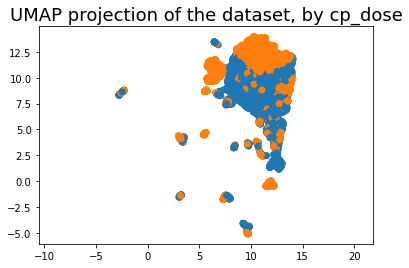

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in train.cp_dose.map({"D1":0, "D2":1})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset, by cp_dose', fontsize=18)

In [ ]:
###################
###################
# What exactly do we want to visualize... What do we want to delineate between, with colors?  What do the smaller blobs mean? 
# Perhaps blobs match with certain drugs???
###################
###################

## Pre-Processing

Random Split of Data



In [ ]:
np.random.seed(42)
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index

unused_feat = ['Set', 'sig_id'] # Let's not use splitting sets and sig_id
features = [ col for col in train.columns if col not in unused_feat] 



In [ ]:
#train.to_csv('train_processed_final.csv')
cat_idxs = [0,1,2]
cat_dims = [2,3,2]

In [ ]:
# def preprocess(data):
#     data = data.copy()
#     data.loc[:, 'cp_type'] = data.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
#     data.loc[:, 'cp_dose'] = data.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
#     data.loc[:,'cp_time'] = data.loc[:,'cp_time'] / 3
#     del data['sig_id']
#     return data

# train = preprocess(train)
# test = preprocess(test)
# #del test_targets['sig_id']
# del train_targets['sig_id']
# train
# control_data = train[train['cp_type'] == 0]
# control_24 = control_data[control_data['cp_time'] == 0] ##Control data for cp_time = 24
# train.loc[train['cp_time'] == 0,'g-1'] -= control_24['g-1'].mean()
# train
#control_24['g-1'].mean()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,Set
0,0,1,0,0,1.181637,0.898347,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,...,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,0
1,1,1,2,0,0.074300,0.408700,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,...,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,1
2,2,1,1,0,0.628000,0.581700,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,...,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,0
3,3,1,1,0,-0.513800,-0.249100,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,...,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0
4,4,1,2,1,-0.325400,-0.400900,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,...,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,23809,1,0,1,0.259037,0.277047,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397,-0.9260,-0.2424,-0.6686,0.2326,0.6456,0.0136,-0.5141,-0.6320,0.7166,-0.1736,...,0.4024,-0.0895,0.4420,0.9641,-0.1846,-0.0014,0.3154,-0.2071,-0.

In [ ]:
###z-Score normalization of pertubation (g1p-g1c / var(g1c)) (g1c is average gene ex for g1 in contorl)
###Normalize dependent on the cp_time...
def z_Score_norm(train):
  GENES = [col for col in train.columns if col.startswith('g-')]
  CELLS = [col for col in train.columns if col.startswith('c-')]
  control_data = train[train['cp_type'] == 0]
  control_24 = control_data[control_data['cp_time'] == 0] ##Control data for cp_time = 24
  control_48 = control_data[control_data['cp_time'] == 1]
  control_72 = control_data[control_data['cp_time'] == 2]

  for col in (GENES+CELLS):
    train.loc[train['cp_time'] == 0, col] -= control_24[col].mean()
    train.loc[train['cp_time'] == 0, col] /= control_24[col].std()

    train.loc[train['cp_time'] == 1, col] -= control_48[col].mean()
    train.loc[train['cp_time'] == 1, col] /= control_48[col].std()

    train.loc[train['cp_time'] == 2, col] -= control_72[col].mean()
    train.loc[train['cp_time'] == 2, col] /= control_72[col].std()

  return train

In [ ]:
print('Logloss before quantile normalization...', 0.13073)
print('Logloss after quantile normalization...', 0.17533)


Logloss before quantile normalization... 0.13073
Logloss after quantile normalization... 0.17533


Fit and transform to qunatile normalized data before PCA. 

In [ ]:
# def quantile_transform(X_train):
#   useless_col = ['Unnamed: 0', 'sig_id', 'cp_type', 'cp_time', 'cp_dose', 'set']
#   for col in useless_col:
#     if col in X_train.columns:
#       X_train.drop(columns=[col])
#   print(X_train)
#   transformer = QuantileTransformer(n_quantiles=100,random_state=42, output_distribution="normal")
#   X_train = transformer.fit_transform(X_train.values)
#   return X_train

In [ ]:
'Quantile Normalization of all gene and cell data...'
def quantile_transform(train_processed, test): 
  GENES = [col for col in train_processed.columns if col.startswith('g-')]
  CELLS = [col for col in train_processed.columns if col.startswith('c-')]

  for col in (GENES + CELLS):

      transformer = QuantileTransformer(n_quantiles=100,random_state=42, output_distribution="normal")
      vec_len = len(train_processed[col].values)
      vec_len_test = len(test[col].values)
      raw_vec = train_processed[col].values.reshape(vec_len, 1)
      transformer.fit(raw_vec)

      train_processed[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
      test[col] = transformer.transform(test[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]
  return train_processed, test

In [ ]:
train_processed, _ = quantile_transform(train_processed, test)
train_processed_vals = train_processed.drop(columns=['Unnamed: 0', 'sig_id','Set']).values
train_processed_vals.shape

(23814, 875)

Find mean for cell viability for control and trt group...

In [ ]:
def show_mean_cell_viability(train_processed):
  CELLS = [col for col in train_processed.columns if col.startswith('c-')]
  control_data = train_processed[train_processed['cp_type'] == 0]
  trt_data = train_processed[train_processed['cp_type'] == 1]
  CELLS_control = control_data[CELLS]
  CELLS_trt = trt_data[CELLS]
  CELLS_ctl_mean = CELLS_control.mean().values
  CELLS_trt_mean = CELLS_trt.mean().values
  plt.figure(figsize=(16,8))
  plt.bar(x=np.arange(100), height=CELLS_ctl_mean, label="Control Data")
  plt.bar(x=np.arange(100), height=CELLS_trt_mean, label="Treatment Data")
  plt.xlabel("c-", size=14)
  plt.ylabel("Average viability data", size=14)
  plt.title("Average viability for control and treatment data")
  plt.legend(loc='upper right')
  #plt.savefig("overlapping_histograms_with_matplotlib_Python.png")
  return 0 

0

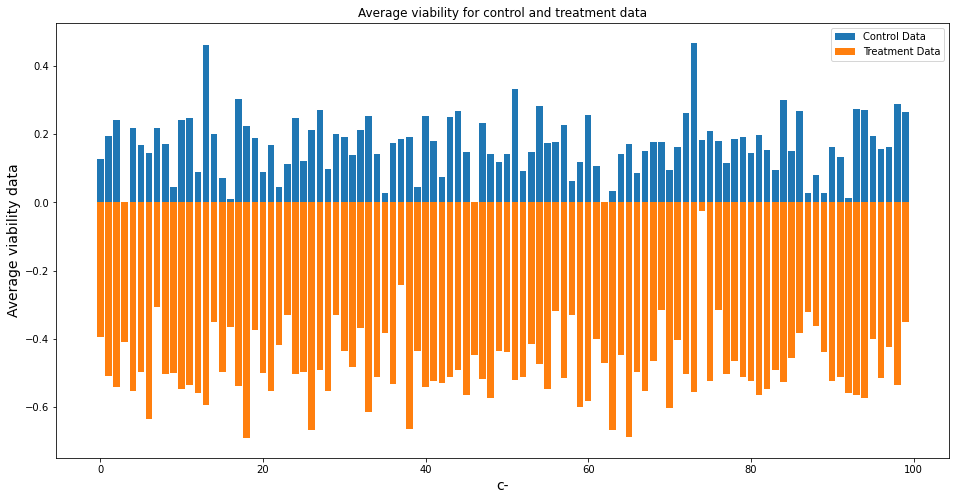

In [ ]:
show_mean_cell_viability(train_processed)

0

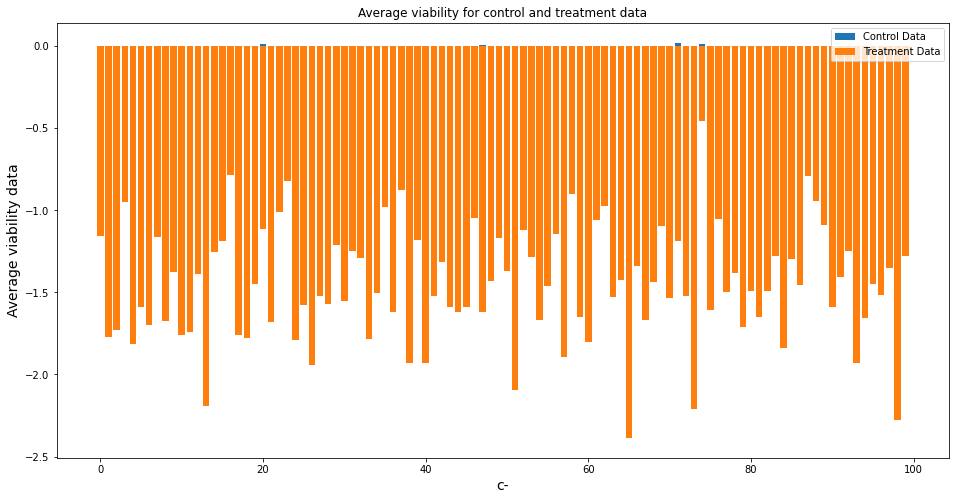

In [ ]:
z_score_train = z_Score_norm(train_processed)
show_mean_cell_viability(train_processed)

## Define, Train, Validate our Network

In [ ]:
def train_TabNet(train, train_targets, test, device='cpu', z_Score_normalize=False, pca=False, n_pca_comp=0, QuantileTransform=False, learn_rate=2e-2, batch_size=512, max_epochs=90):
  
  ###Split Data, drop unused columns
  np.random.seed(42)

  if "Set" in train.columns:
    train = train.drop(columns=['Set'])
  if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))

  train_indices = train[train.Set=="train"].index
  valid_indices = train[train.Set=="valid"].index
  unused_feat = ['Set', 'sig_id', 'Unnamed: 0'] # Let's not use splitting sets and sig_id
  features = [ col for col in train.columns if col not in unused_feat] 

  cat_idxs = [0,1,2] #first three sections of data are categorical...
  cat_dims = [2,3,2]

###############
#process it first... drop unused_feat, split, encode
###############

  ###Further pre-processing...
  if z_Score_normalize == True:
    train = z_Score_norm(train)
  
  if pca == True:
    train = myPCA(train, inference=True, ncomponents=n_pca_comp).components_ ##will cause error as it collapses the columns

  if QuantileTransform == True:
    train, test = quantile_transform(train, test)

  X_train = train[features].values[train_indices]
  y_train = train_targets.values[train_indices]
  X_valid = train[features].values[valid_indices] ###Validation data...
  y_valid = train_targets.values[valid_indices]

  X_test = test[features].values
  TabNet = TabNetMultiTaskClassifier(n_steps=1,
                                cat_idxs=cat_idxs,
                                cat_dims=cat_dims,
                                cat_emb_dim=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=learn_rate),
                                scheduler_params={"step_size":50, # how to use learning rate scheduler
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax', # "sparsemax",
                                lambda_sparse=0, # don't penalize for sparser attention
                                device_name=device,
  )

  #TabNet = torch.load(TabNet_path) 
  print(batch_size)
  print('training shapes:',X_train.shape,y_train.shape)
  print('validation shapes:',X_valid.shape, y_valid.shape)
  TabNet.fit(
    X_train=X_train, y_train=y_train,
    max_epochs=max_epochs ,
    patience=50, # please be patient ^^
    batch_size=batch_size,
    virtual_batch_size=batch_size/4,
    num_workers=1,
    drop_last=False,
    loss_fn= torch.nn.functional.binary_cross_entropy_with_logits # torch.nn.functional.nll_loss
  )    
  # # scores displayed here are -average of log loss
  return TabNet, X_valid, y_valid

In [ ]:
##Can delete...

# TabNet = TabNetMultiTaskClassifier(n_steps=1,
#                                 cat_idxs=cat_idxs,
#                                 cat_dims=cat_dims,
#                                 cat_emb_dim=1,
#                                 optimizer_fn=torch.optim.Adam,
#                                 optimizer_params=dict(lr=2e-2),
#                                 scheduler_params={"step_size":50, # how to use learning rate scheduler
#                                                   "gamma":0.9},
#                                 scheduler_fn=torch.optim.lr_scheduler.StepLR,
#                                 mask_type='entmax', # "sparsemax",
#                                 lambda_sparse=0, # don't penalize for sparser attention
#                                 device_name='cpu',
# )

# TabNet = torch.load(TabNet_path)                

In [ ]:
#print(train_processed.shape,train_targets.shape)
TabNet, X_valid, y_valid = train_TabNet(train_processed, train_targets, test, z_Score_normalize=False, device='cpu', max_epochs=50)

In [ ]:
train_processed.shape,train_targets.shape

((23814, 878), (23814, 206))

In [ ]:
y_pred = TabNet.predict(X_valid)
y_pred = np.asarray(y_pred).T
print('After z-Score normalization')
classification_accuracy(y_valid, y_pred)
classification_accuracy_samples(y_valid, y_pred)

After z-Score normalization
Number of correctly predicted MoA 0.9966138903402716
Number of perfectly predicted samples 0.3992490613266583


0.3992490613266583

In [ ]:
train_targets.shape

(23814, 206)

In [ ]:
np.where(y_pred == 1)[0]

array([   3,    3,   20, ..., 4784, 4785, 4785])

In [ ]:
TabNet_path = os.path.join(GOOGLE_DRIVE_PATH, "TabNet_no_zScore.pt")
torch.save(TabNet, TabNet_path) # uncomment to save your checkpoint


In [ ]:
submission_12 = pd.read_csv(DATA_PATH+'/submission.csv')
np_submission = submission_12.values
np.where(np_submission == 1)

(array([], dtype=int64), array([], dtype=int64))

#### Train

In [ ]:
TabNet.loss_fn

In [ ]:
# plot losses (drop first epochs to have a nice plot)
plt.plot(TabNet.history['train']['loss'][5:])
plt.plot(TabNet.history['valid']['loss'][5:])

In [ ]:
# plot learning rates
plt.plot([x for x in TabNet.history['train']['lr']][5:])

### Validate

AttributeError: ignored

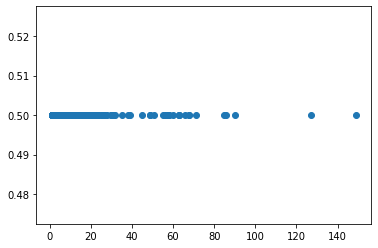

In [ ]:
preds_valid = TabNet.predict_proba(X_valid) # This is a list of results for each task

# We are here getting rid of tasks where only 0 are available in the validation set
valid_aucs = [roc_auc_score(y_score=task_pred[:,1], y_true=y_valid[:, task_idx])
             for task_idx, (task_pred, n_pos) in enumerate(zip(preds_valid, y_valid.sum(axis=0))) if n_pos > 0]

valid_logloss = [log_loss(y_pred=task_pred[:,1], y_true=y_valid[:, task_idx])
             for task_idx, (task_pred, n_pos) in enumerate(zip(preds_valid, y_valid.sum(axis=0))) if n_pos > 0]

plt.scatter(y_valid.sum(axis=0)[y_valid.sum(axis=0)>0], valid_aucs)

# Valid score should match mean log loss - They don't match exactly because we removed some tasks
print(f"BEST VALID SCORE FOR {X_valid} : {TabNet.best_cost}")
print(f"VALIDATION MEAN LOGLOSS SCORES FOR {X_valid} : {np.mean(valid_logloss)}")
print(f"VALIDATION MEAN AUC SCORES FOR {X_valid} : {np.mean(valid_aucs)}")

### Predictions

In [ ]:
preds = TabNet.predict_proba(X_test)

NameError: ignored

In [ ]:
y_pred = TabNet.predict(X_valid)
y_pred = np.asarray(y_pred).T
# print(y_valid.shape)
# print(np.asarray(y_pred).T.shape)
# print(y_pred[0])
print('y_pred are done')
print('log loss is :',log_loss(y_valid,y_pred))

y_test_pred = TabNet.predict(X_test)
y_test_pred = np.asarray(y_test_pred).T
sig_id_test = test['sig_id'].to_numpy()

y_test_pred = np.concatenate((np.expand_dims(sig_id_test,1),y_test_pred),axis=1)

y_pred are done
log loss is : 3.716399229960857


In [ ]:
print(X_test.shape)

In [ ]:
TabNet_path = os.path.join(GOOGLE_DRIVE_PATH, "TabNet.pt")
torch.save(TabNet, TabNet_path) # uncomment to save your checkpoint

####Load PUT AFTER TABNET INITIALIZATION
# TabNet = TabNet.to(dtype=torch.float32, device='cuda')
# TabNet.load_state_dict(torch.load(weights_path)) # uncomment to load your previous checkpoint

In [ ]:
y_test_pred_PATH = os.path.join(GOOGLE_DRIVE_PATH, "y_test_pred.pt")
torch.save(y_test_pred, y_test_pred_PATH) # uncomment to save your checkpoint

# frcnn_detector = TwoStageDetector().to(dtype=torch.float32, device='cuda')
# frcnn_detector.load_state_dict(torch.load(weights_path)) # uncomment to load your previous checkpoint

In [ ]:
torch.save(TabNet,'TabNet.pt')#,GOOGLE_DRIVE_PATH)
torch.save(y_test_pred,'y_test_pred.pt')

In [ ]:
GOOGLE_DRIVE_PATH

In [ ]:
y_test_pred == y_valid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [ ]:
def classification_accuracy(y_valid, y_pred):
  assert y_valid.shape == y_pred.shape
  M, N = y_valid.shape
  acc = np.sum(y_valid == y_pred) / (M*N)
  print('Number of correctly predicted MoA', acc)
  return acc

In [ ]:
classification_accuracy(y_valid,y_pred)

Number of correctly predicted MoA 0.9966138903402716


0.9966138903402716

In [ ]:
booler = y_valid == y_pred
np.array_equal(booler[0],np.ones_like(booler[0]))

True

In [ ]:
def classification_accuracy_samples(y_valid, y_pred):
  assert y_valid.shape == y_pred.shape
  M, N = y_valid.shape
  booler = (y_valid == y_pred)
  count = 0
  for i in range(M):
    if (np.array_equal(booler[i],np.ones_like(booler[0]))):
      count += 1

  acc = count / (M)
  print('Number of perfectly predicted samples', acc)
  return acc

In [ ]:
classification_accuracy_samples(y_valid, y_pred)

Number of perfectly predicted samples 0.3992490613266583


0.3992490613266583

# Evaluation

In [ ]:
unused_feat = ['sig_id','Unnamed: 0', 'Set']
features = [ col for col in train.columns if col not in unused_feat] 

train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))
train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index

X_train = train_processed[features].values[train_indices]
y_train = train_targets.values[train_indices]
X_valid = train_processed[features].values[valid_indices] ###Validation data...
y_valid = train_targets.values[valid_indices]

In [ ]:
TabNet = torch.load(GOOGLE_DRIVE_PATH+'/TabNet.pt')

In [ ]:
def test_sensitivity(train_targets, predictions):

  M, N = train_targets.shape
  assert (train_targets.shape == predictions.shape)
  zeros = torch.zeros(predictions.shape[N])

  total = 0 ##number of times there is a MoA
  correct = 0 ## number of times we predictly classify MoA when there is one..
  for i in range(M):
    
    MoA_apparent = (train_targets[i] != zeros)
    if MoA_apparent:
      total += 1 
      if train_targets[i] == predictions[i]:
        correct += 1
  
  sensitivity = correct / total
  print(sensitivtiy*100,"% sensitivity at finding a MoA where there is one..")
  return sensitivity

In [ ]:
#predictions = TabNet.predict(torch.tensor(data=X_valid))

# Mosaic

In [5]:
#Checks whether the 
def check_labels_the_same(drug_labels):
  count = 0
  total = 0
  for i in range(len(drug_labels) - 1):
    for j in range(5):
      total += 1
      if np.all(drug_labels[i].to_numpy()[j] == drug_labels[i].to_numpy()[j+1]):
        count += 1 
      else:
        print('not the same... At drug', i, 'index ', j)
  if (total == count):
    print('theyre all the same!')
  print('total..', total, 'count correct..', count)
  return 0

In [6]:
'Creates a list that contains the 6 unique pertubations for each drug'
'Input: train -> Unprocessed train data.    train_targets -> labels for train data'

'Output: drugs_gathered -> a list of length N containing (6,896) arrays'
'drug_labels -> GT labels for each pertubation..'

def gather_6_row_drugs(train,train_drug,train_targets):

  M = train['sig_id'].shape[0]
  drug_id_list = [] ### The drug_ids that have been gathered... size N
  drugs_gathered = [] ### Contains drug_ids respective 6 samples... length of 2774 of arrays (6,876)
  drugs_labels = [] ## May not need this.. Labels for each of the 6 samples. length 2774 of arrays (6,206)
  for i in range(M):

    drug_id = train_drug['drug_id'][i]
    if (drug_id not in drug_id_list):
      drug_id_list.append(drug_id)
    else:
      continue

    sig_ids = train_drug[train_drug['drug_id'] == drug_id]['sig_id'].index

    curr_drug = train.loc[sig_ids] ## shape (6,877)
    if curr_drug.shape[0] is not 6:
      continue
    drugs_gathered.append(curr_drug)
    curr_drug_labels = train_targets.loc[sig_ids] 
    drugs_labels.append(curr_drug_labels) ##may not need this...

  return drugs_gathered, drugs_labels

In [7]:
def sort_by_dose_time(drugs_gathered):

  sorted = []
  for drug in drugs_gathered:
    drug = drug.sort_values(by=['cp_dose','cp_time'])
    sorted.append(drug)
  return sorted

In [8]:
drugs_gathered, drugs_labels = gather_6_row_drugs(train,train_drug,train_targets)
drugs_gathered = sort_by_dose_time(drugs_gathered) ##shape (2774,6,876)

In [9]:
drugs_gathered[2]

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
3812,id_28bedaf41,trt_cp,24,D1,-0.6920,-1.4790,-0.3777,0.0246,1.6090,0.3430,-0.0461,-0.2431,-0.2404,-0.2185,0.3619,0.0355,-0.2200,-0.7052,-0.7001,-0.6141,0.7277,0.1164,-0.0712,-1.2330,-0.0260,0.1285,0.3301,-0.4699,0.1274,-0.2328,-0.2584,0.0764,0.0331,-0.0377,0.4739,-0.6689,0.0272,1.1500,-1.6180,0.0752,...,0.1561,-0.2188,-0.5323,0.5059,1.1750,0.0997,-0.4721,0.5865,0.9939,-0.1774,0.3584,0.3387,0.3827,1.6570,-0.3388,0.2381,-0.5615,0.3575,1.3750,-0.3352,-0.4092,0.2877,-0.3014,0.6533,0.2070,0.2527,0.1075,0.4070,0.0539,0.1721,0.5989,0.3661,-0.1294,0.9925,0.9167,0.5772,0.3716,0.7288,0.7314,1.0380
19455,id_d0c8d6d38,trt_cp,48,D1,-0.7895,0.2293,-0.4081,0.3002,-0.7551,0.2006,-1.0910,0.1152,0.1189,0.8963,0.2643,0.7033,-0.2707,-0.0925,-0.0471,0.4584,-0.1440,-1.0290,-0.2870,-0.0537,-0.4431,0.1661,-0.8899,-0.4617,-0.0898,-0.2475,0.9365,-0.5398,0.0384,-0.6298,0.4048,-0.4459,-0.0235,0.1595,0.3088,-0.9607,...,0.0138,0.8632,0.6052,0.1557,0.6812,0.1024,0.1169,-0.7162,-0.0861,0.1384,0.1982,0.9001,-0.1454,0.2476,-0.0257,0.8520,-0.7296,0.2127,-0.3500,-0.4149,0.1394,0.3538,0.7931,0.3961,-0.1398,0.8974,0.0691,0.5804,-0.2163,0.6458,-0.2680,0.3378,0.5797,-0.1498,0.4345,-0.2774,0.3290,-0.0139,0.4623,-0.0776
14935,id_a09620969,trt_cp,72,D1,-0.9434,0.3857,0.8022,0.2833,-0.9582,0.7171,-1.1470,-0.3612,0.1568,0.2265,0.8246,2.3480,0.3523,-0.0779,0.1328,0.8364,0.4699,0.4742,0.0503,-0.5618,-0.9144,-0.9331,0.1742,0.3711,0.0954,-1.2280,0.2706,0.9794,-0.2675,-0.7667,-0.1138,0.0088,0.7272,-0.2371,0.6671,0.0831,...,1.1690,0.7754,0.2531,0.2896,0.8993,-0.3769,0.6069,0.3099,0.2247,-0.0194,0.7126,0.2933,0.6700,0.5626,0.2799,0.9834,0.6202,0.3758,0.2678,0.9341,0.6090,0.4997,0.3010,0.4901,0.7154,0.5087,0.5911,1.4990,0.7024,0.6634,1.0770,0.3297,0.8120,0.2849,0.5969,-0.2240,0.3819,0.4222,-0.1062,0.4088
16950,id_b661a670c,trt_cp,24,D2,0.3067,0.7684,-0.7964,-0.1172,0.5333,-0.1243,-0.8983,0.5133,0.4773,0.0583,0.9606,-0.2549,-0.2957,0.0363,0.1673,0.0968,1.0210,-0.3244,-0.5915,-0.1011,-1.0710,0.7993,-0.1686,-0.2448,-0.0799,-0.3994,0.2315,0.7028,-0.6618,-0.5602,0.0513,-0.9208,0.3148,0.4922,0.0124,-0.5710,...,0.7869,-0.2083,0.2465,-0.0604,0.5884,0.2004,0.7662,0.0764,-1.1350,0.1797,-0.1752,0.1519,0.6178,-1.0760,1.6020,-0.1671,0.3744,0.2741,-0.4783,-0.8270,0.4035,-0.3602,-1.3830,-0.7062,-0.8816,0.1091,-0.1934,0.6590,1.1220,-0.6857,-0.1032,0.7132,-0.2199,0.6086,1.0840,0.7121,-0.1247,0.2255,0.3934,0.0033
11289,id_795f4f2fe,trt_cp,48,D2,0.2623,0.0256,-1.2580,0.9501,0.1718,0.1374,0.2849,0.6244,-0.0805,-0.0028,0.3143,0.5350,0.2395,-0.0783,0.4566,-0.7955,0.3040,-1.0940,0.9583,0.1220,-0.1793,0.1720,-0.6914,-1.0100,-0.2230,-1.1330,-0.0063,0.6203,0.1091,0.0358,0.3591,-0.2946,0.5637,0.4621,-0.1848,-0.3691,...,0.4053,0.2634,0.7548,0.9276,0.8559,0.6533,1.1090,0.9559,0.6681,0.4816,0.6439,0.2818,-0.1687,0.2160,-0.3972,0.5638,-0.1209,0.3790,0.3731,-0.0613,0.6953,0.7566,0.5188,-0.1950,1.0320,1.2360,0.8094,1.1900,0.8358,0.1291,0.2556,0.1541,0.2505,0.3928,-0.1503,0.4197,0.8113,0.1263,-0.3889,-0.0001
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [ ]:
drugs_gathered[0]['c-80']

0        1.2120
13774   -0.6770
22507    0.4766
20190    0.4607
6175     0.9055
14257    1.3960
Name: c-80, dtype: float64